<a href="https://colab.research.google.com/github/njkhorasani/mutiScComplePattern/blob/main/dynamicPattern2SCs2Sigs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can run this code on google Colab.



For the first step you need to install all the packages which are needed.



Follow these ateps: In the menue bar: Edit tab => Network Settings => Hardware accelerator: Choose T4 GPU.


In your Google Drive, in "Colab Notebooks" Folder, create a new Folder and rename it as "sigPatStudy" ("/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/").


You also need to create following Folder in the following path:


"/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/dataPreModel/"


In [2]:
import cupy as cp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import pylab

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')

import pickle
import math

from scipy import stats as st

FolderAddress="/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/"

Mounted at /content/gdrive


In [10]:
# it sets the minimum value of "mat" matrix as "lowBound" and
# sets the maximum value of "mat" matrix as "upBound".
def setMinMax(mat,lowBound,upBound):
  tmp=mat
  tmp = cp.minimum(tmp,upBound)
  tmp = cp.maximum(tmp,lowBound)
  return tmp

#it gets some coordinates, and its neigbors as inputs
#as an output it returns the neigbor coordinates, but the ones which are out of dish
#are replaced
# this function is used to find neighbors of a specific node,
# but it does not choose the neighbors out of dish.
def keepInDish(r1,r2,twoDindexTupple,dishRadius,cntr,dishExistance):
  tmp=cp.where(dishExistance[r1,r2]==0)
  r1[tmp]=twoDindexTupple[0][tmp]
  r2[tmp]=twoDindexTupple[1][tmp]
  # r1=r1[tmp1[0]]
  # r2=r2[tmp1[0]]
  return r1,r2

# it gets a tupple of coordinates as input([],[]), and it returns a matrix of size
# dishSize*dishSize, H11. each element in H11, like H11[i][j] determines the number of
# coordinate[i,j] in the input tupple(twoDindexTupple).
# for twoDindexTupple=([0,1,1,1,2],[2,1,1,2,1]) and dishSize=3 H11 would be:
# [[0,0,1],[0,2,1],[0,1,0]]
def cupyHistogram2d(twoDindexTupple,dishSize):
  #ref: https://math.stackexchange.com/questions/2328749/convert-a-pair-of-integers-to-a-integer-optimally
  maxVal2computeUniqVal=dishSize
  twoDindexTuppletmp=(twoDindexTupple[0]+1,twoDindexTupple[1]+1)
  uniqVal=(twoDindexTuppletmp[0]-1)*maxVal2computeUniqVal+twoDindexTuppletmp[1]
  # print(uniqVal)
  uniqVal=cp.concatenate([uniqVal,cp.asarray([1,dishSize*dishSize])])
  # print(uniqVal)
  H, edge=cp.histogram(uniqVal, bins=dishSize*dishSize)
  # print(H)
  H11=cp.reshape(H,(dishSize,dishSize))
  H11[dishSize-1][dishSize-1]=H11[dishSize-1][dishSize-1]-1
  H11[0][0]=H11[0][0]-1
  # print(H11)
  return H11

# it computes dt based on all the reactions exist in Mat
# Mat id a matrix of propensity function value
def computeDT(Mat,dtLowerBound):
  tmprnd=cp.random.rand(dishSize,dishSize)
  # print(tmprnd)
  tmprndRev=1/tmprnd
  # print(tmprndRev)
  tmprndRevLog=cp.log(tmprndRev)
  # print(tmprndRevLog)
  dt=cp.maximum((1/cp.sum(Mat))*cp.sum(tmprndRevLog),dtLowerBound)
  return dt

#it gets twoDindexTupple as original coordinates in the form of tupple of arrays,
# ([1*n],[1*n]),and it return their 8 neighbors in a form of two matrices of the size
# 8*n, neigMatR keeps the index of rows and neigMatC keeps the index of columns
# in v2:
# it is called by V3
# it keeps it in dish
def determine8neighborsV2(twoDindexTupple,lowerBound,upperBound,dishRadius,cntr,
                          dishExistance):
  sz=twoDindexTupple[0].size
  #8 possible neghbors indeces
  ar=[[1,1],[-1,-1],[1,-1],[-1,1],[0,1],[1,0],[-1,0],[0,-1]]
  neigMatR=cp.zeros((8,sz))#8: directions, 2: rows, and columns,...
  neigMatC=cp.zeros((8,sz))
  #computing the 8 neighbors for all pixels candidate for diffusion
  for i in range(8):
    tmpInd=(twoDindexTupple[0]+ar[i][0],twoDindexTupple[1]+ar[i][1])
    # print(tmpInd)
    r1=setMinMax(tmpInd[0],lowerBound,upperBound)
    r2=setMinMax(tmpInd[1],lowerBound,upperBound)
    # print(r1,"\n",r2)
    # input()
    r1,r2=keepInDish(r1,r2,twoDindexTupple,dishRadius,cntr,dishExistance)
    # print(r1,"\n",r2)
    neigMatR[i]=r1
    neigMatC[i]=r2

  return neigMatR,neigMatC


  # it gets twoDindexTupple as original coordinates in the form of tupple of arrays,
# ([1*n],[1*n]),and it returns one neighbor for each coordinate, the neighbor
# which is more probable to receive the molecule which is diffusing.
# the probability corresponds to the concentration diff
# in V2 version: in previus version, from each cell, signals diffuse to the
#neighbor cell which contains least value of signal molecule
#here signals diffuse to a neighbor cell that:
#(sig. of curr cell-sig. of neigh. cell) has the most value and
# sig. of curr cell>sig. of neigh. cell
# in v3:
# we keep it in dish ;) by calling determine8neighborsV2
def defineNeighbeourPositionsREgarding2ConcenGradientV3(twoDindexTupple,
                                                      lowerBound,upperBound,
                                                      dishRadius,cntr,S,
                                                      dishExistance):
  sz=twoDindexTupple[0].size

  sMat=cp.zeros((8,sz))

  neigMatR,neigMatC=determine8neighborsV2(twoDindexTupple,lowerBound,upperBound,
                                        dishRadius,cntr,
                                        dishExistance)

  co=0
  for r1,r2 in zip(neigMatR,neigMatC):
    r1=r1.astype(int)
    r2=r2.astype(int)

    sMat[co]=cp.maximum(S[twoDindexTupple]-S[(r1,r2)],0)
    co+=1


  #compute the probabily of diffusion 2 diff. neighbors based on S numbers
  #from each pixels, moleculars diffuse to neghbors with lower no. of S
  # print(sMat)
  MatSum=cp.sum(sMat,axis=0)

  # MatRatio=cp.divide(sMatInvVal,MatSumInv)#lower values would be more probable for diffusing to
  MatRatio=cp.divide(sMat,cp.maximum(MatSum,0.0001))

  MatCum=cp.cumsum(MatRatio, axis=0)
  # print(MatSum,"\n",MatRatio,"\n",MatCum)
  MatRandNo=cp.random.rand(1,sz)
  MatComp=MatCum>MatRandNo
  MatComp=MatComp.astype(int)
  # print(MatRandNo,"\n",MatComp)
  MatWhichNeighRows=cp.argmax(MatComp,axis=0)
  MatWhichNeighCols=cp.arange(sz)

  r=neigMatR[(MatWhichNeighRows,MatWhichNeighCols)].astype(int)
  c=neigMatC[(MatWhichNeighRows,MatWhichNeighCols)].astype(int)
  #where we can not diffuse at all
  tmp0 = cp.where(MatSum==0)
  if tmp0[0].size>0:
    r[tmp0], c[tmp0]= twoDindexTupple[0][tmp0], twoDindexTupple[1][tmp0]
  # print(r,c)
  neighTupple=(r,c)

  return neighTupple

# it creates a dish, in a way that SC1, and SC2 are randomly distributed on that
# the probability of the presence of SC1 is stmPrb, and
# the probability of the presence of SC2 is prgPrb
def initializingDish(stmPrb,prgPrb,dishSize):
  dish=cp.zeros((dishSize,dishSize))
  randTmp=cp.random.rand(dishSize,dishSize)

  stmPos=cp.where(cp.logical_and(randTmp<=stmPrb,randTmp>0))
  prgPos=cp.where(cp.logical_and(randTmp<=stmPrb+prgPrb,
                                 randTmp>stmPrb))

  dish[stmPos]=1
  dish[prgPos]=2

  return dish

# it updates the state of a stem cell, SC1, based on the number of it's determinants
# the possible interactions for each SC1 is:
# increasing/decreasing of it's determinants OR Division
def stmCellUpdating(dishSize,reactionNo,Xs,Ys,S1,S2,S1S2scaleVal,
                  alphaPxAbsVal,alphaPyAbsVal,betaP,gammaP,nP,FinalTimeAsCoef,
                    dish,XYlimit2Div,Umax1,Umax2,mxVal3ScaleU,
                    co,itBeforeDiv,roundd):

  PRGNO=sum(sum((dish==1).astype(int)))
  tmp=(dish==1).astype(int)
  alowwed4Div=cp.logical_or(Xs>=XYlimit2Div,Ys>=XYlimit2Div).astype(int)
  alowwed4Div*=tmp

  if (co>itBeforeDiv or roundd>1):
    S1 = (S1/Umax1*mxVal3ScaleU).astype(int)
    S2 = (S2/Umax2*mxVal3ScaleU).astype(int)

    S1=S1*tmp
    S2=S2*tmp

    #scaling S1 and S2 values
    bet = mxVal3ScaleU/2
    Sef1 = (S1**8/(S1**8+bet**8)) * (S2**8/(S2**8+bet**8))*S1S2scaleVal
    Sef2 = (bet**8/(S1**8+bet**8)) * (bet**8/(S2**8+bet**8))*S1S2scaleVal
  else:
    Sef1 = 0
    Sef2 = 0

  alphaPx=alphaPxAbsVal+Sef1
  alphaPy=alphaPyAbsVal+Sef2

  Mat=cp.zeros((reactionNo,dishSize,dishSize))

  tmp1=cp.power(Xs,nP)
  tmp2=cp.power(Ys,nP)

  Mat[0][:][:]=(  (alphaPx*tmp1)/(betaP**nP+tmp1)+(alphaPxAbsVal*betaP**nP)/(betaP**nP+tmp2)  )*tmp

  Mat[1][:][:]=(gammaP*Xs)*tmp

  Mat[2][:][:]=(  (alphaPy*tmp2)/(betaP**nP+tmp2)+(alphaPyAbsVal*betaP**nP)/(betaP**nP+tmp1)   )*tmp
  Mat[3][:][:]=(gammaP*Ys)*tmp

  Mat[4][:][:]=((1/FinalTimeAsCoef)*PRGNO)*tmp*alowwed4Div#division
  return Mat

# it updates the state of a stem cell, SC2, based on the number of it's determinants
# the possible interactions for each SC2 is:
# increasing/decreasing of it's determinants OR Division
def prgCellUpdating(dishSize,reactionNo,Xp,Yp,S1,S2,S1S2scaleVal,
                  alphaPxAbsVal,alphaPyAbsVal,betaP,gammaP,nP,FinalTimeAsCoef,
                    dish,XYlimit2Div,Umax1,Umax2,mxVal3ScaleU,
                    co,itBeforeDiv,roundd):

  PRGNO=sum(sum((dish==2).astype(int)))
  tmp=(dish==2).astype(int)
  alowwed4Div=cp.logical_or(Xp>=XYlimit2Div,Yp>=XYlimit2Div).astype(int)
  alowwed4Div*=tmp

  if (co>itBeforeDiv or roundd>1):
    S1 = (S1/Umax1*mxVal3ScaleU).astype(int)
    S2 = (S2/Umax2*mxVal3ScaleU).astype(int)

    S1=S1*tmp
    S2=S2*tmp

    #scaling S1 and S2 values
    bet = mxVal3ScaleU/2
    Sef1 = (bet**8/(S1**8+bet**8)) * (S2**8/(S2**8+bet**8))*S1S2scaleVal
    Sef2 = (S1**8/(S1**8+bet**8)) * (bet**8/(S2**8+bet**8))*S1S2scaleVal
  else:
    Sef1 = 0
    Sef2 = 0

  alphaPx=alphaPxAbsVal+Sef1
  alphaPy=alphaPyAbsVal+Sef2

  Mat=cp.zeros((reactionNo,dishSize,dishSize))

  tmp1=cp.power(Xp,nP)
  tmp2=cp.power(Yp,nP)

  Mat[0][:][:]=(  (alphaPx*tmp1)/(betaP**nP+tmp1)+(alphaPxAbsVal*betaP**nP)/(betaP**nP+tmp2)  )*tmp

  Mat[1][:][:]=(gammaP*Xp)*tmp

  Mat[2][:][:]=(  (alphaPy*tmp2)/(betaP**nP+tmp2)+(alphaPyAbsVal*betaP**nP)/(betaP**nP+tmp1)   )*tmp
  Mat[3][:][:]=(gammaP*Yp)*tmp

  Mat[4][:][:]=((1/FinalTimeAsCoef)*PRGNO)*tmp*alowwed4Div#division
  return Mat

  # this function determines the fate of each new off-spring at the time of it's birth
# the fate is determined based on the value of it's determinants exactly after birth, and
# the borders of the three attaractors' domains as it is explained in the paper, and references.
def determineNewPcellPhenotype(finalCounter,cntrPrg,alphaPxAbsVal,alphaPyAbsVal,betaP,gammaP,nP,X,Y):
  dt=0.1

  X0,Y0=X,Y
  alphaPx=alphaPxAbsVal
  alphaPy=alphaPyAbsVal
  for i in range(finalCounter):
    tmp1=cp.power(X,nP)
    tmp2=cp.power(Y,nP)
    dx=(alphaPx*tmp1)/(betaP**nP+tmp1)+(alphaPx*betaP**nP)/(betaP**nP+tmp2)-gammaP*X

    dy=(alphaPy*tmp2)/(betaP**nP+tmp2)+(alphaPy*betaP**nP)/(betaP**nP+tmp1)-gammaP*Y
    dx*=dt
    dy*=dt
    # print(dx,dy)
    X=X+dx
    Y=Y+dy
  # print(X,"\n",Y)
  dis=cp.zeros((3,X.size))
  for i in range(3):
    dis[i]=(X-cntrPrg[i,0])**2+(Y-cntrPrg[i,1])**2

  # 1:A/2:B/0:P    in dish: p:2 A:3  B:4 => 1==>3 2==>4  0==>2
  phenTmp=cp.argmin(dis,axis=0)
  # print(phenTmp)
  # 1==>3 2==>4  0==>2
  phenTmp[cp.where(phenTmp==1)]=3
  phenTmp[cp.where(phenTmp==2)]=4
  phenTmp[cp.where(phenTmp==0)]=2
  # print(phenTmp)
  return phenTmp

  # it updates the S_u signal based on Equation 1
def signalUpdating4SCTurU(dishSize,U, V,reactionNo,
                   whereSPrd, GausTur, Umax):
  Mat = cp.zeros((reactionNo,dishSize,dishSize))
  alpha, beta, C, gamma, Du, Dv = .9, 1.2, .2, 10000, 1, 20

  if GausTur==2:
    # Umin, Umax = 0, 5#4, 10, 50, 500,5
    # ScU, ScV = 16, 16
    ScU, ScV = 25, 25
  if GausTur==3:
    # Umin, Umax = 0, 10#4, 10, 50, 500,5
    ScU, ScV = 1, 1
  if  GausTur==4:
    # Umin, Umax = 0, 30#4, 10, 50, 500,5
    ScU, ScV = 1, 1

  h = .01
  CoScl = 1/(h**2)


  Mat[0][:][:] = gamma* (alpha*U + C)*whereSPrd
  Mat[1][:][:] = gamma* (V)
  Mat[2][:][:] = Du*U*CoScl * ScU

  return Mat

  # it updates the S_v signal based on Equation 2
def signalUpdating4SCTurV(dishSize,U, V,reactionNo,
                   whereSPrd, GausTur, Umax):

  Mat = cp.zeros((reactionNo,dishSize,dishSize))
  alpha, beta, C, gamma, Du, Dv = .9, 1.2, .2, 10000, 1, 20

  if GausTur==2:
    # Umin, Umax = 0, 5#4, 10, 50, 500,5
    # ScU, ScV = 16, 16
    ScU, ScV = 25, 25
  if GausTur==3:
    # Umin, Umax = 0, 10#4, 10, 50, 500,5
    ScU, ScV = 1, 1
  if  GausTur==4:
    # Umin, Umax = 0, 30#4, 10, 50, 500,5
    ScU, ScV = 1, 1

  h = .01
  CoScl = 1/(h**2)

  Mat[0][:][:] = gamma* (beta*U)*whereSPrd
  Mat[1][:][:] = gamma* (V+1)
  Mat[2][:][:] = Dv*V*CoScl* ScV

  # print("U min and max: ", U.min(), U.max())

  return Mat

  # it counts the number of different types of off-springs after the division of SC1
def  toCountPhStm(phTC, phTN, U1tmp, U2tmp,Umax1,Umax2,mxVal3ScaleU):
  U1tmp = (U1tmp/Umax1*mxVal3ScaleU).astype(int)
  U2tmp = (U2tmp/Umax2*mxVal3ScaleU).astype(int)
  phStmMatTmp = cp.zeros((3,mxVal3ScaleU+1,mxVal3ScaleU+1))


  for i in range(mxVal3ScaleU+1):
    for j in range(mxVal3ScaleU+1):
      curV = 2**i*3**j
      curIn = cp.where(2**U1tmp*3**U2tmp==curV)[0]

      tC = phTC[curIn]
      tN = phTN[curIn]
      tmpC = cp.where(tC==2)[0].size+cp.where(tN==2)[0].size
      phStmMatTmp[0,i,j] += tmpC

      tmpC = cp.where(tC==3)[0].size+cp.where(tN==3)[0].size
      phStmMatTmp[1,i,j] += tmpC

      tmpC = cp.where(tC==4)[0].size+cp.where(tN==4)[0].size
      phStmMatTmp[2,i,j] += tmpC


  return phStmMatTmp


  # it counts the number of different types of off-springs after the division of SC2
def  toCountPhPrg(phTC, phTN, U1tmp, U2tmp,Umax1,Umax2,mxVal3ScaleU):
  U1tmp = (U1tmp/Umax1*mxVal3ScaleU).astype(int)
  U2tmp = (U2tmp/Umax2*mxVal3ScaleU).astype(int)
  phPrgMatTmp = cp.zeros((3,mxVal3ScaleU+1,mxVal3ScaleU+1))

  for i in range(mxVal3ScaleU+1):
    for j in range(mxVal3ScaleU+1):
      curV = 2**i*3**j
      curIn = cp.where(2**U1tmp*3**U2tmp==curV)[0]

      tC = phTC[curIn]
      tN = phTN[curIn]
      tmpC = cp.where(tC==2)[0].size+cp.where(tN==2)[0].size
      phPrgMatTmp[0,i,j] += tmpC

      tmpC = cp.where(tC==3)[0].size+cp.where(tN==3)[0].size
      phPrgMatTmp[1,i,j] += tmpC

      tmpC = cp.where(tC==4)[0].size+cp.where(tN==4)[0].size
      phPrgMatTmp[2,i,j] += tmpC

  return phPrgMatTmp


  # it checks the error value to determine if the simulation should be terminated
# the details is described in algorithm 1.
def checkTerminationCond(phStmMat,phPrgMat,MatRatio_old,mxVal3ScaleU,ErVal):
  szzz = mxVal3ScaleU+1
  phSPMat = cp.zeros((6,szzz,szzz))
  phSPMat[0,:,:] = phStmMat[0,:,:]
  phSPMat[1,:,:] = phStmMat[1,:,:]
  phSPMat[2,:,:] = phStmMat[2,:,:]
  phSPMat[3,:,:] = phPrgMat[0,:,:]
  phSPMat[4,:,:] = phPrgMat[1,:,:]
  phSPMat[5,:,:] = phPrgMat[2,:,:]

  MatSum=cp.sum(phSPMat,axis=0)
  MatRatio=cp.divide(phSPMat,cp.maximum(MatSum,0.00001))

  mxVal = cp.max(abs(MatRatio - MatRatio_old))
  if mxVal <= ErVal:
    flg = 1
  else:
    flg = 0
  print(mxVal)
  # print(MatRatio,'\n', MatRatio_old)
  return flg, MatRatio, mxVal


  #it gets twoDindexTupple as original coordinates in the form of tupple of arrays,
# ([1*n],[1*n]),and it return their 8 neighbors in a form of two matrices of the size
# 8*n, neigMatR keeps the index of rows and neigMatC keeps the index of columns
# in v2:
# it is called by V3
# it keeps it in dish
def determine8neighborsV2(twoDindexTupple,lowerBound,upperBound,dishRadius,cntr,
                          dishExistance):
  sz=twoDindexTupple[0].size
  #8 possible neghbors indeces
  ar=[[1,1],[-1,-1],[1,-1],[-1,1],[0,1],[1,0],[-1,0],[0,-1]]
  neigMatR=cp.zeros((8,sz))#8: directions, 2: rows, and columns,...
  neigMatC=cp.zeros((8,sz))
  #computing the 8 neighbors for all pixels candidate for diffusion
  for i in range(8):
    tmpInd=(twoDindexTupple[0]+ar[i][0],twoDindexTupple[1]+ar[i][1])
    # print(tmpInd)
    r1=setMinMax(tmpInd[0],lowerBound,upperBound)
    r2=setMinMax(tmpInd[1],lowerBound,upperBound)
    # print(r1,"\n",r2)
    # input()
    r1,r2=keepInDish(r1,r2,twoDindexTupple,dishRadius,cntr,dishExistance)
    # print(r1,"\n",r2)
    neigMatR[i]=r1
    neigMatC[i]=r2

  return neigMatR,neigMatC


  # it plots the state of the dish based on the probabilities asigned to each cell type
# the probabilities are calculated based on the values in phStmMat,phPrgMat
# corresponding to SC1, and SC2 cells.
def showPhDishV2(phStmMat,phPrgMat,mxVal3ScaleU,U1,U2,Umax1,Umax2,rp):
#############################################################
  dishSize = len(U1)
  szzz = mxVal3ScaleU+1
  phSPMat = cp.zeros((6,szzz,szzz))
  phSPMat[0,:,:] = phStmMat[0,:,:]
  phSPMat[1,:,:] = phStmMat[1,:,:]
  phSPMat[2,:,:] = phStmMat[2,:,:]
  phSPMat[3,:,:] = phPrgMat[0,:,:]
  phSPMat[4,:,:] = phPrgMat[1,:,:]
  phSPMat[5,:,:] = phPrgMat[2,:,:]

  U1tmp = (U1/Umax1*mxVal3ScaleU).astype(int)
  U2tmp = (U2/Umax2*mxVal3ScaleU).astype(int)
  phCount4Dish = cp.zeros((6,dishSize,dishSize))


  for i in range(mxVal3ScaleU+1):
    for j in range(mxVal3ScaleU+1):

      curV = 2**i*3**j
      curIn = cp.where(2**U1tmp*3**U2tmp==curV)

      phCount4Dish[0,curIn[0],curIn[1]] = phSPMat[0, i,j]
      phCount4Dish[1,curIn[0],curIn[1]] = phSPMat[1, i,j]
      phCount4Dish[2,curIn[0],curIn[1]] = phSPMat[2, i,j]
      phCount4Dish[3,curIn[0],curIn[1]] = phSPMat[3, i,j]
      phCount4Dish[4,curIn[0],curIn[1]] = phSPMat[4, i,j]
      phCount4Dish[5,curIn[0],curIn[1]] = phSPMat[5, i,j]
#############################################################
  # rp = 100
  MatOperations = cp.zeros((rp,dishSize,dishSize))
  coMt = 0
  MatSum2=cp.sum(phCount4Dish,axis=0)
  MatRatio2=cp.divide(phCount4Dish,cp.maximum(MatSum2,0.00001))
  MatCum2=cp.cumsum(MatRatio2, axis=0)
  ###############################################################
  for i in range(rp):
    MatRandNo2=cp.random.rand(dishSize,dishSize)
    MatComp2=MatCum2>MatRandNo2
    MatComp2=MatComp2.astype(int)
    MatOperations1=cp.argmax(MatComp2,axis=0)
    whreOpIsValid2=(MatSum2!=0).astype(int)-1
    MatOperations1+=whreOpIsValid2
    MatOperations[coMt,:,:] = MatOperations1
    coMt += 1

  modeInfo = st.mode(cp.asnumpy(MatOperations),axis = 0)
  # mxMatOperations = cp.array(modeInfo[0][0])
  mxMatOperations = cp.array(modeInfo[0])

  mxMatOperations[0,0] = 0
  mxMatOperations[0,1] = 5
  cmp = 'gist_rainbow_r'
  plt.imshow(cp.asnumpy(mxMatOperations.astype(int)), cmap = cmp)
  plt.colorbar()
  plt.show()
  plt.close()

  return mxMatOperations


def ComputeDtT(Mat1,Mat2,Mat3,dtLowerBound):
  if Mat1.max()>0:
    dt1=computeDT(Mat1,dtLowerBound)
  else:
    dt1=0
  dt2=computeDT(Mat2,dtLowerBound)
  dt3=computeDT(Mat3,dtLowerBound)

  dtt = max(dt1,dt2,dt3)
  return dtt

In the following section, you need to determine the version of the code you would like to run. This version value helps us to save the data and be able to retrieve them for next steps.

In [11]:
whichVer2Run = input("which ver u are running?\n(suggested: 1, 2, ...) ")

whichSubVer2save= '1'
FileName4savingMats="".join(("statev",whichVer2Run,"-",whichSubVer2save))

#determining folders for loading and saving:
where2saveFolderName = "".join(("data",whichVer2Run,"/",str(whichSubVer2save)))
where2saveAllVarsFolderName = "".join(("ModelData",whichVer2Run,"/",str(whichSubVer2save)))

where2save = "".join((FolderAddress,where2saveFolderName,"/"))
where2saveVars = FolderAddress+"dataPreModel/"

where2saveAllVars = "".join((FolderAddress,where2saveAllVarsFolderName,"/"))

which ver u are running?
(suggested: 1, 2, ...) 100


In [12]:
# in this part the model parameters are set

# dish Shape: 2 => square,
shapeOfDish=2
##
dishSize=100
cntr=[(dishSize-1)/2,(dishSize-1)/2]
dishRadius=dishSize/2
maxNoForSig1No=0

radiusPrdS1=0
how2DiffFlag=6

freqPrb=0.#which percent of cells in regions are occupied by A/B cells
stmPrb,prgPrb=.5, 0.5#0.15 empty pixels
upperBound=dishSize-1
lowerBound=0

#prg. cell para.
#if a cell is chosen to divide, it feels the S1 and S2 value of its neighbors as well
#how far neighbors should be considered is determined by neighNo4effectOfNeighSig
neighNo4effectOfNeighSig = 1
neighNo4S12Det = 3
#if Xp and Yp would not catch mid attractor val, the effect of S1 and S2 is not
#visualized yet
XYplimit2Div=85#cells with less than "XYplimit2Div" of Xp and Yp can not divide,
#Mid attractor for alphas=30,30 is equal to 78
phPrg=cp.zeros(3)#for counting phenotypes
divKindPrg = cp.zeros(3)#for counting div.. kinds PP,PD,DD
finalCounter=1000
cntrPrg=cp.array([[78.9,78.9],[157.3,.5],[.5,157.3]])
XYpLowerBnd=10
maxNoForXpYpNo=80
alphaPxAbsVal=30
alphaPyAbsVal=30
betaP = 42#47.5
gammaP=0.38
nP=4
coef4PrgDiv=10#it controls the rate of division
################################
alphSCsig =10000
KSCsig =   0
DSCsig =   2500000
S1S2scaleVal = 20#10
################################
mxVal3ScaleU = 5
phPrgMat = cp.zeros((3,mxVal3ScaleU+1,mxVal3ScaleU+1))#P, A, B
phStmMat = cp.zeros((3,mxVal3ScaleU+1,mxVal3ScaleU+1))
################################
#stop condition:
szzz = mxVal3ScaleU+1
MatRatio_old = cp.zeros((6,szzz,szzz))
ErVal = 0.0025
################################
MatIndexCols=cp.zeros((dishSize,dishSize))
MatIndexRows=cp.zeros((dishSize,dishSize))
for i in range(dishSize):
  MatIndexCols[i][:]=cp.arange(dishSize)
  MatIndexRows[i][:]=MatIndexRows[i][:]+i

MatDisFromCntr=cp.sqrt((MatIndexCols-cntr[1])**2+(MatIndexRows-cntr[0])**2)

#determining Time
t,dtLowerBound = 0,0
# FinalTime, FinalTimeAsCoef = detremineTimePars(dishExistance)
defaultNoOfCellsInDish = int(50*50*math.pi)
# currentNoOfCellsInDish = cp.where(dishExistance==1)[0].size
expectedVal4n = .91
currentNoOfCellsInDish = dishRadius**2*math.pi*expectedVal4n
tmpRatio = currentNoOfCellsInDish/defaultNoOfCellsInDish
FinalTimeAsCoef = 5000* tmpRatio
# FinalTime = 5000* math.sqrt(tmpRatio)
FinalTime = 5000

roundd = 1

# start time point
t=0

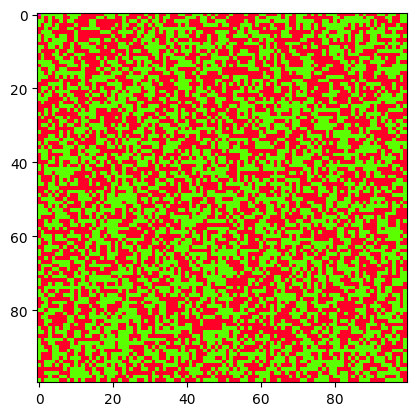

In [13]:
# it initialize the dish randomly in square shape, and then show it to us

# initializing the disg status
dish=initializingDish(stmPrb,prgPrb,dishSize)

U1=cp.zeros((dishSize, dishSize))

U2=cp.zeros((dishSize, dishSize))

##initializing Xp and Yp
Xp=cp.random.randint(maxNoForXpYpNo, size=(dishSize, dishSize))
Xp=Xp*(dish==2).astype(int)
Yp=cp.random.randint(maxNoForXpYpNo, size=(dishSize, dishSize))
Yp=Yp*(dish==2).astype(int)
##initializing Xs and Ys
Xs=cp.random.randint(maxNoForXpYpNo, size=(dishSize, dishSize))
Xs=Xs*(dish==1).astype(int)
Ys=cp.random.randint(maxNoForXpYpNo, size=(dishSize, dishSize))
Ys=Ys*(dish==1).astype(int)

dishExistance = cp.ones((dishSize,dishSize))


# plot the dish
dishPLT=dish.copy()
dishPLT[0,0]=-1
plt.imshow(cp.asnumpy(dishPLT),cmap='gist_rainbow_r')
plt.show()
plt.close()
del dishPLT

In [14]:
# here you need to determine the type of signalling patterns
# we need two types of signalling patterns to be able to continue the code
# Therefore it asks you to determine first and second signalling patterns

sMaxVal = 250
stopSSyn = 1

if stopSSyn==1:
  # SS1 = cp.zeros((dishSize, dishSize))
  GausTur1 = int(input("2: inv. spot 3: strip 4: spot : "))
  Umin = 0
  Umax1 = 5*int(GausTur1==2) +10*int(GausTur1==3) + 30*int(GausTur1==4)
  U1 = cp.random.randint(0,Umax1, (dishSize,dishSize))
  V1 = cp.random.randint(0,Umax1, (dishSize,dishSize))

sMax1 = 5*int(GausTur1==2) +10*int(GausTur1==3) + 30*int(GausTur1==4)

stopSSyn = 1
if stopSSyn==1:
  # SS2 = cp.zeros((dishSize, dishSize))
  GausTur2 = int(input("2: inversed spot 3: strip 4: spot patterns: "))
  Umin = 0
  Umax2 = sMaxVal*int(GausTur2==1)+5*int(GausTur2==2) +10*int(GausTur2==3) + 30*int(GausTur2==4)
  U2 = cp.random.randint(0,Umax2, (dishSize,dishSize))
  V2 = cp.random.randint(0,Umax2, (dishSize,dishSize))

sMax2 = 5*int(GausTur2==2) +10*int(GausTur2==3) + 30*int(GausTur2==4)

# 'how many it. u wanna wait before potential division starts:
tmp1 = 20000*int(GausTur1==2) +10000*int(GausTur1==3) + 12000*int(GausTur1==4)
tmp2 = 20000*int(GausTur2==2) +10000*int(GausTur2==3) + 12000*int(GausTur2==4)
itBeforeDiv = max(tmp1,tmp2);

# the counter for counting the iterations
co = 0
rp = 200

2: inv. spot 3: strip 4: spot : 3
2: inversed spot 3: strip 4: spot patterns: 3


This is the main part of code.


it start with a randoly distributed SC1, and SC2 in the population.

In the first phase of the simulation before the interation number reaches the value of "itBeforeDiv", the signalling patterns are formed. in each 500 iterations, we can see the updated status of signald S_u_1, and SU_2.


As soon as they are formed the potential divisions in the population starts and we can see the population status in each 500 iterations.

You need to wait until the error value is less than a certain value (ErVal = 0.0025). It takes around 15 min when I am running on my Apple M2 Pro system.


This part of code illusterates how signalling patterns ae formed, and that the desired patterns in the population can be formed corresponding to the formed environmental signalling patterns.


after each 100 iterations, all the variables of the simulation are stored as a ".pkl" file in the directory of "dataPreModel". It can be loaded later for more analysis.

In [ ]:
savingDivCoStep=1

while(t<FinalTime):
  if co>itBeforeDiv+35000 and co%1000==0:
    flg = int(input('1: continue!, 0: stop!'))
    if flg == 0:
      break
  if co>itBeforeDiv and co%1000==0:
    flg2, MatRatio_old, mxErVal = checkTerminationCond(phStmMat,phPrgMat,MatRatio_old,mxVal3ScaleU,ErVal)
    print('max. Error Val.: ', mxErVal)
    if flg2 == 1:
      flg = int(input('1: continue!, 0: stop!'))
      if flg == 0:
        break
  co+=1
  ####################
  divAllowance = 0
  if co%100==0:
    divAllowance = 100
  ####################
  # #to show the code advance
  if co%500==0 and co>itBeforeDiv:
    showPhDishV2(phStmMat,phPrgMat,mxVal3ScaleU,U1,U2,Umax1,Umax2,rp)
    # print('max. Error Val.: ', mxErVal)
  if co%500==0:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(cp.asnumpy(U1),cmap='gist_rainbow_r')
    axs[1].imshow(cp.asnumpy(U2),cmap='gist_rainbow_r')
    plt.show()
    plt.close()

    # fig, axs = plt.subplots(1, 2)
    # # plt.gca().set_aspect('equal', adjustable='box')
    # tmpP=cp.where(dish==2)
    # axs[0].plot(cp.asnumpy(Xp[tmpP]),cp.asnumpy(Yp[tmpP]),'.')
    # axs[0].plot([0,90,180],[180,90,0],'.')
    # # plt.gca().set_aspect('equal', adjustable='box')
    # tmpP=cp.where(dish==1)
    # axs[1].plot(cp.asnumpy(Xs[tmpP]),cp.asnumpy(Ys[tmpP]),'.')
    # axs[1].plot([0,90,180],[180,90,0],'.')
    # # plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()
    # plt.close()

#########################################
    print("time:",t,dt1,dt2,"count:",co)

  if co%100==0:
    tmp=(where2saveVars,FileName4savingMats,'.pkl')
    f = open("".join(tmp), 'wb')
    pickle.dump([Xs,Ys,Xp,Yp,U1,V1,U2,V2,dish,phPrgMat,phStmMat], f)
    f.close()

  #updating divisio no:

  ##########################
  ##cell transfer mat
  ScellNo=(cp.where(dish==1))[0].size
  PcellNo=(cp.where(dish==2))[0].size
  ##prg. cell interactions Mat
  reactionNoPrg=5
  # print(U2[1,15:30])
  stmMat = stmCellUpdating(dishSize,reactionNoPrg,Xs,Ys,U1,U2,S1S2scaleVal,
                      alphaPxAbsVal,alphaPyAbsVal,betaP,gammaP,nP,FinalTimeAsCoef,
                        dish,XYplimit2Div,Umax1,Umax2,mxVal3ScaleU,
                        co,itBeforeDiv,roundd)
  # print(U2[1,15:30])
  prgMat = prgCellUpdating(dishSize,reactionNoPrg,Xp,Yp,U1,U2,S1S2scaleVal,
                  alphaPxAbsVal,alphaPyAbsVal,betaP,gammaP,nP,FinalTimeAsCoef,
                    dish,XYplimit2Div,Umax1,Umax2,mxVal3ScaleU,
                    co,itBeforeDiv,roundd)




  if GausTur1 == 2 or GausTur1 == 3 or GausTur1 == 4:
    reactionNo = 3
    whereSPrd=(dish>0).astype(int)#determines where S can be produced
    stmMatSig11 = signalUpdating4SCTurU(dishSize,U1,V1,reactionNo,
                   whereSPrd, GausTur1,Umax1)
    stmMatSig12 = signalUpdating4SCTurV(dishSize,U1,V1,reactionNo,
                   whereSPrd, GausTur1, Umax1)


  if GausTur2 == 2 or GausTur2 == 3 or GausTur2 == 4:
    reactionNo = 3
    whereSPrd=(dish>0).astype(int)#determines where S can be produced
    stmMatSig21 = signalUpdating4SCTurU(dishSize,U2,V2,reactionNo,
                   whereSPrd, GausTur2,Umax2)
    stmMatSig22 = signalUpdating4SCTurV(dishSize,U2,V2,reactionNo,
                   whereSPrd, GausTur2, Umax2)

  ##preparing operation Mat
  reactionNos=6+6+5+5
  Mat=cp.zeros((reactionNos,dishSize,dishSize))
  Mat[0][:][:]=stmMatSig11[0][:][:]#prd
  Mat[1][:][:]=stmMatSig11[1][:][:]#deg
  Mat[2][:][:]=stmMatSig11[2][:][:]#diff
  Mat[3][:][:]=stmMatSig12[0][:][:]
  Mat[4][:][:]=stmMatSig12[1][:][:]
  Mat[5][:][:]=stmMatSig12[2][:][:]

  Mat[6][:][:]=stmMatSig21[0][:][:]#prd
  Mat[7][:][:]=stmMatSig21[1][:][:]#deg
  Mat[8][:][:]=stmMatSig21[2][:][:]#diff
  Mat[9][:][:]=stmMatSig22[0][:][:]
  Mat[10][:][:]=stmMatSig22[1][:][:]
  Mat[11][:][:]=stmMatSig22[2][:][:]


  Mat[12][:][:]=prgMat[0][:][:]#Xprd
  Mat[13][:][:]=prgMat[1][:][:]#
  Mat[14][:][:]=prgMat[2][:][:]#
  Mat[15][:][:]=prgMat[3][:][:]#Ydeg
  Mat[16][:][:]=prgMat[4][:][:]*1200*divAllowance#div.

  Mat[17][:][:]=stmMat[0][:][:]
  Mat[18][:][:]=stmMat[1][:][:]
  Mat[19][:][:]=stmMat[2][:][:]
  Mat[20][:][:]=stmMat[3][:][:]
  Mat[21][:][:]=stmMat[4][:][:]*1200*divAllowance



  Mat1=Mat[0:6][:][:]
  Mat2=Mat[6:12][:][:]
  Mat3=Mat[12:22][:][:]

  ##Choosing operations1
  MatSum1=cp.sum(Mat1,axis=0)
  MatRatio1=cp.divide(Mat1,cp.maximum(MatSum1,0.00001))
  MatCum1=cp.cumsum(MatRatio1, axis=0)

  MatRandNo1=cp.random.rand(dishSize,dishSize)
  MatComp1=MatCum1>MatRandNo1
  MatComp1=MatComp1.astype(int)
  MatOperations1=cp.argmax(MatComp1,axis=0)
  whreOpIsValid1=(MatSum1!=0).astype(int)-1
  MatOperations1+=whreOpIsValid1

  ##Choosing operations2
  MatSum2=cp.sum(Mat2,axis=0)
  MatRatio2=cp.divide(Mat2,cp.maximum(MatSum2,0.00001))
  MatCum2=cp.cumsum(MatRatio2, axis=0)

  MatRandNo2=cp.random.rand(dishSize,dishSize)
  MatComp2=MatCum2>MatRandNo2
  MatComp2=MatComp2.astype(int)
  MatOperations2=cp.argmax(MatComp2,axis=0)
  whreOpIsValid2=(MatSum2!=0).astype(int)-1
  MatOperations2+=whreOpIsValid2

  ##Choosing operations3
  MatSum3=cp.sum(Mat3,axis=0)
  MatRatio3=cp.divide(Mat3,cp.maximum(MatSum3,0.00001))
  MatCum3=cp.cumsum(MatRatio3, axis=0)

  MatRandNo3=cp.random.rand(dishSize,dishSize)
  MatComp3=MatCum3>MatRandNo3
  MatComp3=MatComp3.astype(int)
  MatOperations3=cp.argmax(MatComp3,axis=0)
  whreOpIsValid3=(MatSum3!=0).astype(int)-1
  MatOperations3+=whreOpIsValid3


  if GausTur1==2 or GausTur1==3 or GausTur1==4:
    # production
    tmp=cp.where(MatOperations1==0)
    U1[tmp]=cp.minimum(U1[tmp]+1, Umax1)
    #degredation
    tmp = cp.where(MatOperations1==1)
    U1[tmp] = cp.maximum(U1[tmp]-1, Umin)
    #diffusion
    tmp = cp.where(MatOperations1==2)
    U1[tmp] = cp.maximum(U1[tmp]-1,0)
    OpDifT = defineNeighbeourPositionsREgarding2ConcenGradientV3(tmp,lowerBound,
                                                              upperBound,
                                                              dishRadius,cntr,U1,
                                                              dishExistance)
    H1 = cupyHistogram2d(OpDifT,dishSize)
    U1 += (H1)
    U1 = cp.minimum(U1, Umax1)

    # production
    tmp = cp.where(MatOperations1==3)
    V1[tmp] = V1[tmp]+1
    #degredation
    tmp = cp.where(MatOperations1==4)
    V1[tmp] = V1[tmp]-1
    #diffusion
    tmp = cp.where(MatOperations1==5)
    V1[tmp]=V1[tmp]-1
    OpDifT=defineNeighbeourPositionsREgarding2ConcenGradientV3(tmp,lowerBound,
                                                              upperBound,
                                                              dishRadius,cntr,V1,
                                                               dishExistance)
    H1=cupyHistogram2d(OpDifT,dishSize)
    V1+=(H1)
  if GausTur2==2 or GausTur2==3 or GausTur2==4:
    # production
    tmp=cp.where(MatOperations2==0)
    U2[tmp]=cp.minimum(U2[tmp]+1, Umax2)
    #degredation
    tmp = cp.where(MatOperations2==1)
    U2[tmp] = cp.maximum(U2[tmp]-1, Umin)
    #diffusion
    tmp = cp.where(MatOperations2==2)
    U2[tmp] = cp.maximum(U2[tmp]-1,0)
    OpDifT = defineNeighbeourPositionsREgarding2ConcenGradientV3(tmp,lowerBound,
                                                              upperBound,
                                                              dishRadius,cntr,U2,
                                                              dishExistance)
    H1 = cupyHistogram2d(OpDifT,dishSize)
    U2 += (H1)
    U2 = cp.minimum(U2, Umax2)

    # production
    tmp = cp.where(MatOperations2==3)
    V2[tmp] = V2[tmp]+1
    #degredation
    tmp = cp.where(MatOperations2==4)
    V2[tmp] = V2[tmp]-1
    #diffusion
    tmp = cp.where(MatOperations2==5)
    V2[tmp]=V2[tmp]-1
    OpDifT=defineNeighbeourPositionsREgarding2ConcenGradientV3(tmp,lowerBound,
                                                              upperBound,
                                                              dishRadius,cntr,V2,
                                                               dishExistance)
    H1=cupyHistogram2d(OpDifT,dishSize)
    V2+=(H1)
  ##progenitor cells reactions
  #X prd.
  tmp=cp.where(MatOperations3==0)
  Xp[tmp]=Xp[tmp]+1
  #X deg.
  tmp=cp.where(MatOperations3==1)
  Xp[tmp]=cp.maximum(Xp[tmp]-1,0)
  #Y prd
  tmp=cp.where(MatOperations3==2)
  Yp[tmp]=Yp[tmp]+1
  #Y deg
  tmp=cp.where(MatOperations3==3)
  Yp[tmp]=cp.maximum(Yp[tmp]-1,0)
  # division
  if co%100==0 and (co>itBeforeDiv or roundd>1):
    tmp=cp.where(MatOperations3==4)
    if tmp[0].size>0:
      currPixX=cp.random.binomial(Xp[tmp],0.5)
      neighXp=Xp[tmp]-currPixX

      currPixY=cp.random.binomial(Yp[tmp],0.5)
      neighYp=Yp[tmp]-currPixY

      X=currPixX
      Y=currPixY
      phTCurrPix=determineNewPcellPhenotype(finalCounter,cntrPrg,alphaPxAbsVal,
                                            alphaPyAbsVal,betaP,gammaP,nP,X,Y)

      X=neighXp
      Y=neighYp
      phTNeigh=determineNewPcellPhenotype(finalCounter,cntrPrg,alphaPxAbsVal,
                                          alphaPyAbsVal,betaP,gammaP,nP,X,Y)
      U1tmp = U1[tmp]
      U2tmp = U2[tmp]
      phPrgMat += toCountPhPrg(phTCurrPix, phTNeigh, U1tmp, U2tmp,Umax1,Umax2,mxVal3ScaleU)

  ##stem cells reactions
  #X prd.
  tmp=cp.where(MatOperations3==5)
  Xs[tmp]=Xs[tmp]+1
  #X deg.
  tmp=cp.where(MatOperations3==6)
  Xs[tmp]=cp.maximum(Xs[tmp]-1,0)
  #Y prd
  tmp=cp.where(MatOperations3==7)
  Ys[tmp]=Ys[tmp]+1
  #Y deg
  tmp=cp.where(MatOperations3==8)
  Ys[tmp]=cp.maximum(Ys[tmp]-1,0)
  #division
  if co%100==0 and (co>itBeforeDiv or roundd>1):
    tmp=cp.where(MatOperations3==9)
    if tmp[0].size>0:

        currPixX=cp.random.binomial(Xs[tmp],0.5)
        neighX=Xs[tmp]-currPixX

        currPixY=cp.random.binomial(Ys[tmp],0.5)
        neighY=Ys[tmp]-currPixY

        X=currPixX
        Y=currPixY

        phTCurrPix = determineNewPcellPhenotype(finalCounter,cntrPrg,alphaPxAbsVal,
                                              alphaPyAbsVal,betaP,gammaP,nP,X,Y)

        X=neighX
        Y=neighY

        phTNeigh = determineNewPcellPhenotype(finalCounter,cntrPrg,alphaPxAbsVal,
                                              alphaPyAbsVal,betaP,gammaP,nP,X,Y)
        U1tmp = U1[tmp]
        U2tmp = U2[tmp]
        phStmMat += toCountPhStm(phTCurrPix, phTNeigh, U1tmp, U2tmp,Umax1,Umax2,mxVal3ScaleU)


  #to be sure we have Xp and Yp in right positions
  Xp*=(dish==2).astype(int)
  Yp*=(dish==2).astype(int)
  #to be sure we have Xs and Ys in right positions
  Xs*=(dish==1).astype(int)
  Ys*=(dish==1).astype(int)

  dtt = ComputeDtT(Mat1,Mat2,Mat3,dtLowerBound)
  t += dtt

###################################################


In this part we can restore the pkkl file we hve saved in the last session, and save it's corresponding population status for further analysis.


the population is saved as "popuTest.pkl" file.


##################################################

In [6]:
import cupy as cp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import pylab

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')

import pickle
import math

from scipy import stats as st

FolderAddress="/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/"


# it plots the state of the dish based on the probabilities asigned to each cell type
# the probabilities are calculated based on the values in phStmMat,phPrgMat
# corresponding to SC1, and SC2 cells.
def showPhDishV2(phStmMat,phPrgMat,mxVal3ScaleU,U1,U2,Umax1,Umax2,rp):
#############################################################
  dishSize = len(U1)
  szzz = mxVal3ScaleU+1
  phSPMat = cp.zeros((6,szzz,szzz))
  phSPMat[0,:,:] = phStmMat[0,:,:]
  phSPMat[1,:,:] = phStmMat[1,:,:]
  phSPMat[2,:,:] = phStmMat[2,:,:]
  phSPMat[3,:,:] = phPrgMat[0,:,:]
  phSPMat[4,:,:] = phPrgMat[1,:,:]
  phSPMat[5,:,:] = phPrgMat[2,:,:]

  U1tmp = (U1/Umax1*mxVal3ScaleU).astype(int)
  U2tmp = (U2/Umax2*mxVal3ScaleU).astype(int)
  phCount4Dish = cp.zeros((6,dishSize,dishSize))


  for i in range(mxVal3ScaleU+1):
    for j in range(mxVal3ScaleU+1):

      curV = 2**i*3**j
      curIn = cp.where(2**U1tmp*3**U2tmp==curV)

      phCount4Dish[0,curIn[0],curIn[1]] = phSPMat[0, i,j]
      phCount4Dish[1,curIn[0],curIn[1]] = phSPMat[1, i,j]
      phCount4Dish[2,curIn[0],curIn[1]] = phSPMat[2, i,j]
      phCount4Dish[3,curIn[0],curIn[1]] = phSPMat[3, i,j]
      phCount4Dish[4,curIn[0],curIn[1]] = phSPMat[4, i,j]
      phCount4Dish[5,curIn[0],curIn[1]] = phSPMat[5, i,j]
#############################################################
  # rp = 100
  MatOperations = cp.zeros((rp,dishSize,dishSize))
  coMt = 0
  MatSum2=cp.sum(phCount4Dish,axis=0)
  MatRatio2=cp.divide(phCount4Dish,cp.maximum(MatSum2,0.00001))
  MatCum2=cp.cumsum(MatRatio2, axis=0)
  ###############################################################
  for i in range(rp):
    MatRandNo2=cp.random.rand(dishSize,dishSize)
    MatComp2=MatCum2>MatRandNo2
    MatComp2=MatComp2.astype(int)
    MatOperations1=cp.argmax(MatComp2,axis=0)
    whreOpIsValid2=(MatSum2!=0).astype(int)-1
    MatOperations1+=whreOpIsValid2
    MatOperations[coMt,:,:] = MatOperations1
    coMt += 1

  modeInfo = st.mode(cp.asnumpy(MatOperations),axis = 0)
  # mxMatOperations = cp.array(modeInfo[0][0])
  mxMatOperations = cp.array(modeInfo[0])

  mxMatOperations[0,0] = 0
  mxMatOperations[0,1] = 5
  cmp = 'gist_rainbow_r'
  plt.imshow(cp.asnumpy(mxMatOperations.astype(int)), cmap = cmp)
  plt.colorbar()
  plt.show()
  plt.close()

  return mxMatOperations

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


your save file version? 100


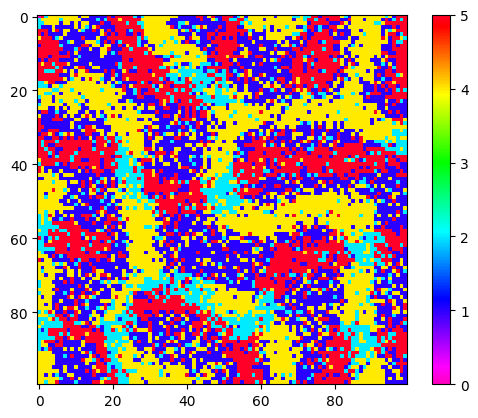

In [8]:
# this saves the population and plots that.
rrp = 200
mxVal3ScaleU = 5
VV = int(input('your save file version? '))

# load the saved file
s=""
tmp=('/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/dataPreModel/',"statev",str(VV),"-1.pkl")
f = open(s.join(tmp), 'rb')
Xs,Ys,Xp,Yp,U1,V1,U2,V2,dish,phPrgMat,phStmMat= pickle.load(f)
f.close()

# load and plot the population
Umax1,Umax2 = U1.max(),U2.max()
popu = showPhDishV2(phStmMat,phPrgMat,mxVal3ScaleU,U1,U2,Umax1,Umax2,rrp)


s=""###
tmp=('/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/dataPreModel/popuTest.pkl')###
f = open(s.join(tmp), 'wb')###
pickle.dump(popu, f)###
f.close()###

########################################################


Algorithm 2.
It retrives a population which is saved previously to test if we can retrieve the corresponding initial patterns which led to forming this complex pattern in the population.


the population is saved as "popuTest.pkl" file.
########################################################

In [2]:
import cupy as cp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import pylab

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')

import pickle
import math

from scipy import stats as st

FolderAddress="/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


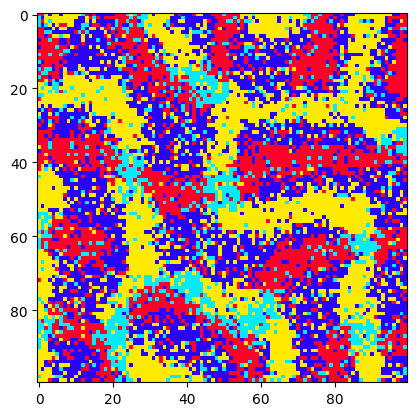

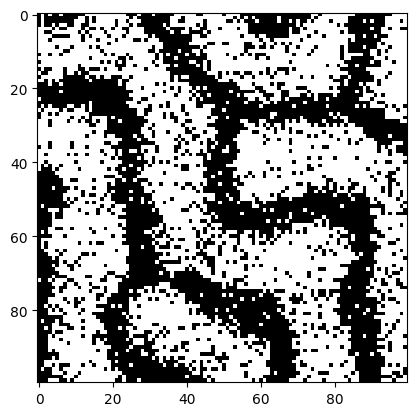

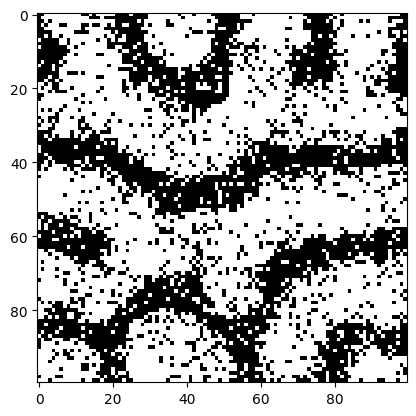

In [3]:
s=""
tmp=('/content/gdrive/My Drive/Colab Notebooks/sigPatStudy/dataPreModel/popuTest.pkl')
f = open(s.join(tmp), 'rb')###
aa = pickle.load(f)
f.close()###


cmp = 'gist_rainbow_r'
plt.imshow(cp.asnumpy(aa.astype(int)), cmap = cmp)
plt.show()
plt.close()

bb = aa.copy()
bb[cp.where(bb==1)] = 1
bb[cp.where(bb==2)] = 0
bb[cp.where(bb==4)] = 0
bb[cp.where(bb==5)] = 1
bb[cp.where(bb==0)] = .5
bb[cp.where(bb==3)] = .5

cmp = 'gray'
plt.imshow(cp.asnumpy(bb.astype(int)), cmap = cmp)
plt.show()
plt.close()

bb = aa.copy()
bb[cp.where(bb==1)] = 1
bb[cp.where(bb==2)] = 0
bb[cp.where(bb==4)] = 1
bb[cp.where(bb==5)] = 0
bb[cp.where(bb==0)] = .5
bb[cp.where(bb==3)] = .5
cmp = 'gray'
plt.imshow(cp.asnumpy(bb.astype(int)), cmap = cmp)
plt.show()
plt.close()